In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import cairo
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

# reproducibility
np.random.seed(0)

2023-01-07 03:47:19.054338: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def getImageLabels(masks):
    
    labels = np.zeros((masks.shape[0], masks.shape[1], masks.shape[2], 4), dtype=np.uint8)

    for i in range(0, masks.shape[0]):
      
      mask_0 = (masks[i] == [  0,  0,  0]).all(axis=2) # backgroud = 0
      mask_1 = (masks[i] >  [100,  0,  0]).all(axis=2) # rectangle = 1
      mask_2 = (masks[i] >  [  0,100,  0]).all(axis=2) # circle    = 2
      mask_3 = (masks[i] >  [  0,  0,100]).all(axis=2) # triangle  = 3
      
      labels[i][mask_0, 0] = 1
      labels[i][mask_1, 1] = 1 
      labels[i][mask_2, 2] = 1
      labels[i][mask_3, 3] = 1
      
    return labels

In [3]:
def normalize_dataset(imgs):
  X = imgs / 255.
  return X

In [4]:
def split_dataset(X, y, train_ratio = 0.8):
  num_imgs = X.shape[0]
  i = int(train_ratio * num_imgs)
  train_X = X[:i]
  test_X = X[i:]
  train_y = y[:i]
  test_y = y[i:]
  return train_X, test_X, train_y, test_y

In [5]:
def show_image(imgs):
  plt.figure(figsize=(8,4))
  plt.subplot(1, 2, 1)
  img_size = imgs[0].shape[0]
  plt.imshow(imgs[0], interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])

In [6]:
def apply_grayscale(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    cv.imshow('gray', gray)
    show_image([gray])

In [7]:
def apply_zoom(img, scale):
    height, width, channels = img.shape
    print(height, width, channels)

    #prepare the crop
    centerX,centerY=int(height/2),int(width/2)
    radiusX,radiusY= int(scale*height/100),int(scale*width/100)

    minX,maxX=centerX-radiusX,centerX+radiusX
    minY,maxY=centerY-radiusY,centerY+radiusY

    print(minX,maxX)
    print(minY,maxY)

    cropped = img[minX:maxX, minY:maxY]
    print(cropped)
    resized_cropped = cv.resize(cropped, (width, height))

    cv.imshow('zoom', resized_cropped)
    show_image([resized_cropped])

In [8]:
def apply_brightness(img, value):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv.merge((h, s, v))
    img = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)

    cv.imshow('brightness', img)
    show_image([img])
    return img

In [9]:
def data_augmentation(img):

    
    pass

In [10]:


def display_mask(mask):
  mask = np.argmax(mask, axis=-1) # (32, 32, n_classes) > (32, 32)
  plt.imshow(np.squeeze(mask), cmap="Greys", interpolation='none', origin='lower', extent=[0, 32, 0, 32])

def display(imgs, masks):
  img_size = imgs[0].shape[0]
  plt.figure(figsize=(16, 8))

  for i, i_subplot in enumerate(range(1, 5)):
    plt.subplot(2, 4, i_subplot)
    plt.imshow(imgs[i], interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])

  for i, i_subplot in enumerate(range(5, 9)): 
    plt.subplot(2, 4, i_subplot)
    mask = np.argmax(masks[i], axis=-1) 
    plt.imshow(np.squeeze(mask), cmap="Greys", interpolation='none', origin='lower', extent=[0, 32, 0, 32])

    plt.axis('off')

  plt.show()

In [11]:
def multiple_shape_dataset(num_imgs = 100, num_objects = 5, img_size = 32, min_object_size = 4, max_object_size = 16):

  imgs = np.zeros((num_imgs, img_size, img_size, 4), dtype=np.uint8)  # format: BGRA
  masks = np.zeros((num_imgs, img_size, img_size, 4), dtype=np.uint8)  # format: BGRA

  num_shapes = 3
  shape_labels = ['rectangle', 'circle', 'triangle']
  
  num_colors = 3
  color_labels = ['r', 'g', 'b']
  

  for i_img in range(num_imgs):

    colors = [tuple(np.random.random(size=3)) for i in range(0,3)]
    
    # cairo imgs
    surface_img = cairo.ImageSurface.create_for_data(imgs[i_img], cairo.FORMAT_RGB24, img_size, img_size)
    cr_img = cairo.Context(surface_img)
    cr_img.set_source_rgb(0, 0, 0) # Fill background white.
    cr_img.paint()

    # cairo mask
    surface_mask = cairo.ImageSurface.create_for_data(masks[i_img], cairo.FORMAT_RGB24, img_size, img_size)
    cr_mask = cairo.Context(surface_mask)
    cr_mask.get_source().set_extend(cairo.EXTEND_REPEAT)

    cr_mask.set_source_rgb(0, 0, 0) # Fill background black.
    cr_mask.paint()

    # Draw random shapes.
    for i_object in range(num_objects):
      shape = np.random.randint(num_shapes)

      if shape == 0:  # rectangle
          w, h = np.random.randint(min_object_size, max_object_size, size=2)
          x = np.random.randint(0, img_size - w)
          y = np.random.randint(0, img_size - h)

          cr_img.rectangle(x, y, w, h)
          cr_img.set_source_rgb(*colors[0]) # red

      elif shape == 1:  # circle   
          r = 0.5 * np.random.randint(min_object_size, max_object_size)
          x = np.random.randint(r, img_size - r)
          y = np.random.randint(r, img_size - r)

          cr_img.arc(x, y, r, 0, 2*np.pi)
          cr_img.set_source_rgb(*colors[1]) # green

      elif shape == 2:  # triangle
          w, h = np.random.randint(min_object_size, max_object_size, size=2)
          x = np.random.randint(0, img_size - w)
          y = np.random.randint(0, img_size - h)

          cr_img.move_to(x, y)
          cr_img.line_to(x+w, y)
          cr_img.line_to(x+w, y+h)
          cr_img.line_to(x, y)
          cr_img.close_path()

          cr_img.set_source_rgb(*colors[2]) # blue

      cr_img.fill()

  imgs = imgs[..., 2::-1]  # is BGRA, convert to RGB

  #show_image(imgs)
  #apply_brightness(imgs[0], 60)
  #apply_zoom(imgs[0], 0.9)
  #apply_grayscale(imgs[0])
  masks = getImageLabels(imgs) # generations of masks from images
  imgs = normalize_dataset(imgs) # normalization of pixels values

  return imgs, masks

In [12]:
# create dataset
imgs, masks = multiple_shape_dataset(num_imgs = 5, num_objects = 5, img_size = 32, min_object_size = 4, max_object_size = 16)

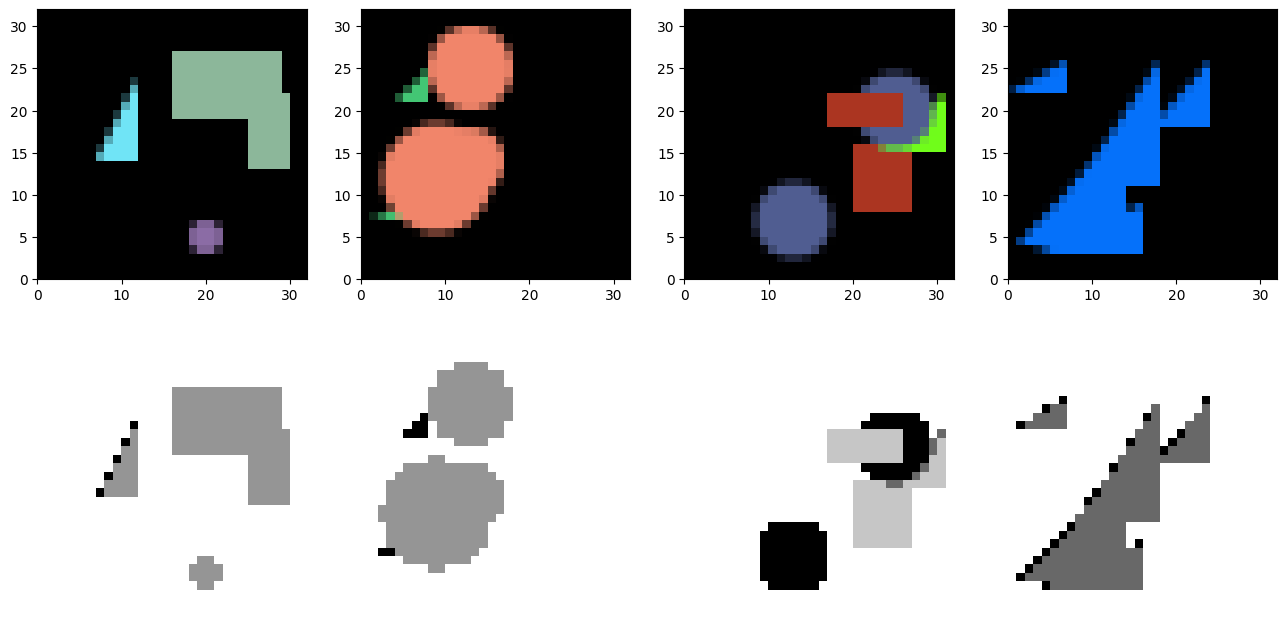

In [13]:
display(imgs, masks)

In [14]:
# import libs
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Add, Activation, Dropout, Convolution2D, Conv2D, MaxPooling2D, Flatten, Conv2DTranspose, Reshape, Lambda, concatenate

import tensorflow.keras.backend as K
K.backend()

'tensorflow'

In [15]:
#build the model
def model_segmentation(n_classes, img_shape):
    model = Sequential()

    inputs = Input(shape=img_shape) ## 224,224,3 ## 

    c1 = Conv2D(32, (3, 3), activation='elu', padding='same') (inputs) 
    c1 = Dropout(0.2) (c1)
    c1 = Conv2D(32, (3, 3), activation='elu', padding='same') (c1)

    p1 = MaxPooling2D((2, 2)) (c1) # downsampling

    c2 = Conv2D(64, (3, 3), activation='elu', padding='same') (p1)
    c2 = Dropout(0.4) (c2)
    c2 = Conv2D(64, (3, 3), activation='elu', padding='same') (c2)

    u1 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same') (c2) # upsampling

    u1 = Add()([u1, c1]) # skip connections

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (u1)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)

    output = Conv2D(n_classes, (3, 3), activation='softmax', padding='same')(c3)

    model = Model(inputs, output)

    model.summary()

    return model

In [16]:
# create dataset
imgs, masks = multiple_shape_dataset(num_imgs = 5000, num_objects = 5, img_size = 32, min_object_size = 4, max_object_size = 16)

In [ ]:
# holdout: 0.8 for training
train_X, test_X, train_y, test_y = split_dataset(imgs, masks)
train_X.shape, train_y.shape

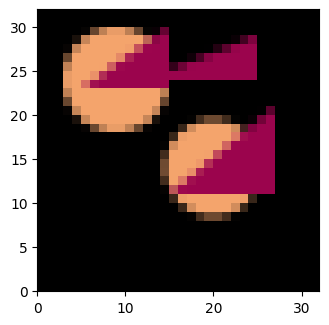

In [20]:
index = 0
show_image(imgs)

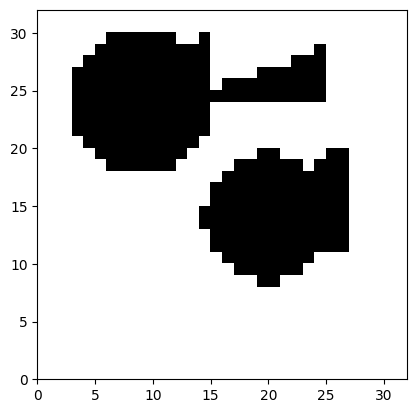

In [21]:
display_mask(masks[index])

In [26]:
model = model_segmentation(n_classes=4, img_shape=(32,32,3))
model.compile('sgd', 'categorical_crossentropy')
model.fit(train_data, epochs=3, batch_size=32, validation_data=val_data)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 32, 32, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 32, 32, 32)   0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 32, 32, 32)   9248        dropout_12[0][0]                 
____________________________________________________________________________________________

In [27]:
test_y_predicted = model.predict(test_data)

display(test_data.classes, test_y_predicted)

AttributeError: 'NumpyArrayIterator' object has no attribute 'classes'

In [ ]:
# mIoU
import tensorflow as tf 
mIoU = tf.keras.metrics.MeanIoU(num_classes=4)

flatted_y_predicted = test_y_predicted.flatten()
flatted_y = test_data.flatten()

mIoU.update_state(test_data, flatted_y_predicted)
mIoU.result().numpy()